# WER on single recording end to end

#### Common packages

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
from graphviz import Digraph
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Amharic

In [4]:
from Cfg import Cfg
C = Cfg('NIST', 8000, 'amharic') 

## Split Corpus into Recordings $\langle A_i,T_i \rangle$

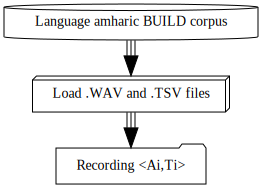

In [40]:
import split_corpus_into_recordings
split_corpus_into_recordings.diagram(C)

In [41]:
from RecordingCorpus import RecordingCorpus
from multiprocessing import Pool
from contextlib import closing
if __name__ == '__main__':
    with closing(Pool(16)) as pool:
        recordings = RecordingCorpus(C, pool)

100%|██████████| 122/122 [00:09<00:00, 13.51it/s]


In [42]:
id_recording={x.key:x for x in recordings.artifacts}

## Split Recordings $\langle A_i,T_i \rangle$ into Splits $\langle A_{i,j}, T_{i,j} \rangle$ following transcript

In [ ]:
import split_recordings_into_splits
split_recordings_into_splits.diagram(C)

In [ ]:
from SplitCorpus import SplitCorpus
splits=SplitCorpus.transcript_split(C, recordings)

In [ ]:
id_splits={x.key:x for x in splits.artifacts}

## Subsplit $A_{i,j}$ on silence and apportion text to trimmed chunks by word sizes in $T_{i,j} = \langle w_{i,j,k} \rangle$ where $w_{i,j,k}=\langle g_{i,j,k,l} \rangle$

In [ ]:
import subsplit_Aij_on_silence_and_apportion_text_by_size
subsplit_Aij_on_silence_and_apportion_text_by_size.diagram

In [ ]:
from SubSplitCorpus import SubSplitCorpus
if __name__=="__main__":
    if False:
        with closing(Pool(16)) as pool:
            subsplits=SubSplitCorpus(pool, splits, min_words=2)
        with open('bfgpu.pkl', 'wb') as f:
            pickle.dump(subsplits,f)
    else:
        with open('bfgpu.pkl', 'rb') as f:
            subsplits=pickle.load(f)

In [ ]:
id_subsplits={x.key:x for x in subsplits.artifacts}

# Train ASR NN on subsplits $\langle A_{i,j,k}, T_{i,j,k} \rangle$ inferring $P_{i,j,k}$

In [ ]:
import train_ASR_NN_on_subsplits
train_ASR_NN_on_subsplits.diagram

In [ ]:
import os
os.environ['IN_JUPYTER']='True'

In [ ]:
from ASR_NN import ASR_NN
model_ASR = ASR_NN(C);
model_ASR.load_model();
model_ASR.load_training_set(subsplits, batch_size=24)
ASR_output = model_ASR.infer()
ASR_scores = model_ASR.score(ASR_output)

Clean up GPU memory for next phase

In [ ]:
import torch
del model_ASR
torch.cuda.empty_cache() 

## Concatenate $P_{i,j,k}$ giving $P_{i,j} = P_{i,j,1}\|\cdots\|P_{i,j,-1}$

In [ ]:
import concatenate_Pikj_giving_Pij
concatenate_Pikj_giving_Pij.diagram

In [ ]:
for order, hyp in ASR_scores[['order','hyp']].values:
    subsplits.artifacts[order].P = hyp

In [ ]:
Pij={x.key[0:-1]:{} for x in subsplits.artifacts}

for x in subsplits.artifacts:
    Pij[x.key[0:-1]][x.key[-1]] = x.P

for key in Pij:
    Pij[key] = ' '.join([y for x,y in Pij[key].items()])

for key in Pij:
    id_splits[key].P=Pij[key]

## Join text corrector training sets $\langle P_{i,j,k}, T_{i,j,k}\rangle$ and $\langle P_{i,j}, T_{i,j}\rangle$ giving training set $\langle P, T\rangle$

In [ ]:
import join_Pijk_and_Pij_giving_P
join_Pijk_and_Pij_giving_P.diagram

In [ ]:
Pijk_Tijk=[(x.P, x.target.value, x) for x in subsplits.artifacts]
In [ ]:
￼
import score_TiQi_using_sclite_on_all_recordings_together
score_TiQi_using_sclite_on_all_recordings_together.diagram
In [ ]:
￼
​


In [ ]:
Pij_Tij=[(y.P, y.target.value, y) for x,y in id_splits.items() if 'P' in vars(y)]

In [ ]:
P_T=Pijk_Tijk+Pij_Tij

In [ ]:
!ls -l pt.pkl

In [5]:
if False:
    with open('pt.pkl', 'wb') as f:
        pickle.dump(P_T, f)
else:
    with open('pt.pkl', 'rb') as f:
        P_T = pickle.load(f)

## Infer text-to-text corrector $P\to Q\approx T$ and score

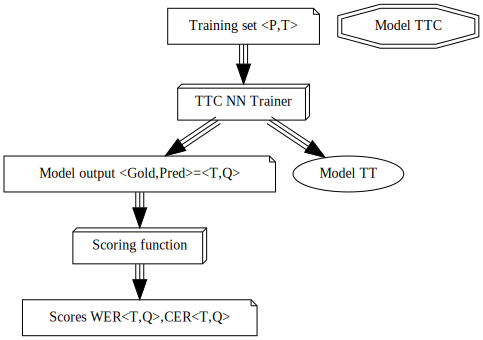

In [6]:
import train_text_to_text_corrector_on_PQT_score
train_text_to_text_corrector_on_PQT_score.diagram

In [7]:
from TTC_NN import TTC_NN

In [8]:
model_TTC = TTC_NN(C);

In [9]:
model_TTC.load_training_set(P_T, 64)

INFO:root:Batch size 64
INFO:root:#Training examples 45208
INFO:root:#graphemes 235


In [10]:
model_TTC.load_model('save/afterburner/afterburner_002_96473_1437.pt');

The model has 4,399,599 trainable parameters


In [ ]:
model_TTC.train(1)

In [31]:
TTC_output = model_TTC.infer()

In [33]:
len(model_TTC.train_data), len(TTC_output)

(45208, 45204)

<IPython.core.display.Javascript object>


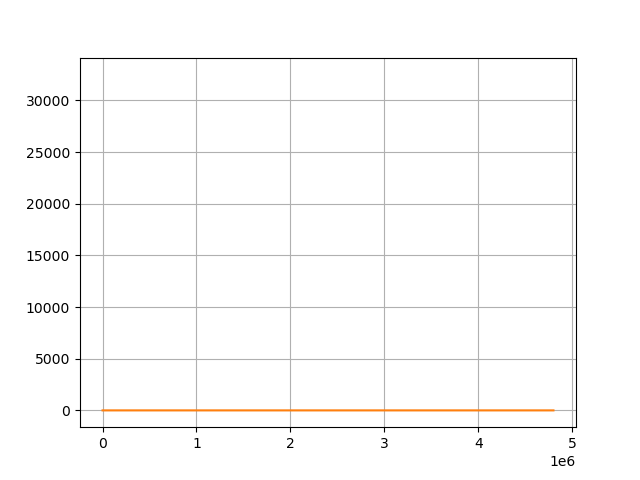

CER mean 0.13607577075970503
WER mean 0.3440286160066393


In [34]:
TTC_scores = model_TTC.score(TTC_output)

In [35]:
TTC_scores

,Gold,Pred,CER,WER,GOLD_n_words,GOLD_n_chars,CER_pct,WER_pct
0,ምናችን ምናችን,ምናችን ምናችን,0,0,2,9,0.000000,0.0000
1,እንደዚህ,እንደዚህ,0,0,1,5,0.000000,0.0000
2,እያጠናህ ነው,እያጠናህ ነው,0,0,2,8,0.000000,0.0000
3,አዎ ዲፌንስ አቀራረቡ በጣም አሪፍ ነበረ ይመቻል እንግዲህ አዎ አቀራረቡ ...,አዎ ዲፌንስ አቀራረቡ በጣም አሪፍ ነበረ ይመቻል እንግዲህ አዎ አቀራረቡ ...,11,2,16,74,0.148649,0.6875
4,አዎ,አዎ,0,0,1,2,0.000000,0.0000
...,...,...,...,...,...,...,...,...
45199,እሺ,እ,1,1,1,2,0.500000,1.0000
45200,ደህና ነው እግዚአብሔር ይመስገን አይሰ,ደህና ነው እግዚአብሔር ይመስገን አይሰ,0,0,5,24,0.000000,0.0000
45201,ማም,ማም,0,0,1,2,0.000000,0.0000
45202,ም እንግዲህ እየደጋገሱ ነው ገና ነው,ም እንግዲህ እየደጋገሱ ነው ገና ነው,0,0,7,24,0.000000,0.0000


In [ ]:
del model_TTC
import torch
torch.cuda.empty_cache()

## Subsplit $A_{i,j}$ on silence alone retaining timecode $(s_{i,j,k},e_{i,j,k})$ giving $A_{i,j} = \langle (\alpha_{i,j,k}, (s_{i,j,k},e_{i,j,k})) \rangle$ so that $\alpha_{i,j,k} = A_{i,j}[s_{i,j,k}:e_{i,j,k}]$

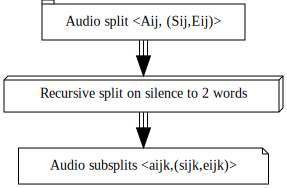

In [39]:
import subsplit_Aij_on_silence_retaining_timecode
subsplit_Aij_on_silence_retaining_timecode.diagram

In [ ]:
ssplits=SplitCorpus.split_on_silence(C, recordings)

In [178]:
(t_lower, t_upper, n_words, window, min_gap, goal_length_in_seconds,sample_rate)=(0.0001,0.8,2,500,10,3,8000)

In [175]:
from split_on_longest_median_low_energy_point import split_on_longest_median_low_energy_point
from midpoint import midpoint
from tqdm.auto import tqdm

In [205]:
def good_large_split_unstripped(sound, t_lower, t_upper, window, min_gap, sample_rate, goal_length_in_seconds):
    if goal_length_in_seconds >= sound.shape[0]/sample_rate:
        return [(0,sound.shape[0])]
    audio_normalized=normalize(sound)
    Right = None
    for t_poke in tqdm(np.linspace(t_lower, t_upper, 10)):
        [(left, startL, endL), Right]=split_on_longest_median_low_energy_point(audio_normalized, window, t_poke, min_gap)
        if Right is not None:
            break
    if Right is None:
        return [(startL, endL)]
    (right, startR, endR)=Right
    t_left = (endL-startL)/sample_rate
    t_right = (endR-startR)/sample_rate
    L = good_large_split_unstripped(left, t_lower, t_upper, window, min_gap, sample_rate, goal_length_in_seconds)
    R = good_large_split_unstripped(right, t_lower, t_upper, window, min_gap, sample_rate, goal_length_in_seconds)
    endL = L[-1][-1]
    R = [(x+endL,y+endL) for x,y in R]
    return L+R

In [206]:
L=good_large_split_unstripped(audio, t_lower, t_upper, window, min_gap, sample_rate, goal_length_in_seconds)

In [226]:
def get_chunk_up_to_size(L,goal_length_in_seconds,sample_rate):
    size=0
    for i, (start,end) in enumerate(L):
        size += (end-start)/sample_rate
        if size >= goal_length_in_seconds:
            i=max(0,i-1)
            break
    return L[0:i+1], L[i+1:]

In [227]:
def chunks_of_size(L,goal_length_in_seconds,sample_rate):
    G=[]
    R=L
    for i in range(len(L)):
        chunk, R = get_chunk_up_to_size(R,goal_length_in_seconds,sample_rate)
        G.append((chunk[0][0], chunk[-1][-1]))
        if not R:
            break
    return G

In [305]:
G=chunks_of_size(L,goal_length_in_seconds,sample_rate)

In [306]:
def clip_ends_adjust_xy(audio, x, y):
    clip, (x1,y1) = clip_ends(audio)
    return clip, (x1+x, y1+x)

In [307]:
A=[clip_ends_adjust_xy(audio[x:y],x,y) for x,y in G]

In [311]:
A1=[x for x in A if x[0].shape[0] > 0]

In [314]:
A2=[(normalize(audio),(x,y)) for audio,(x,y) in A1]

In [239]:
from longest_silence import longest_silence

In [242]:
from aggressive_clip_ends import aggressive_clip_ends

In [252]:
len([x for x in A if len(clip_ends(x[-1])) == 0])

79

In [248]:
level=(foo**2).max()

In [250]:
np.where(foo**2 > level)

(array([], dtype=int64),)

## Infer $(\alpha_{i,j,k}, (s_{i,j,k},e_{i,j,k})) \xrightarrow{ASR} p_{i,j,k} $

In [ ]:
import infer_aijk_giving_pijk
infer_aijk_giving_pijk.diagram

In [ ]:
torch.cuda.empty_cache() 

## Concatenate $p_{i,j,k} \to p_{i,j}$

In [ ]:
import concatenate_pikj_giving_pij
concatenate_pikj_giving_pij.diagram

## Infer $p_{i,j} \xrightarrow{TT} (q_{i,j},(s_{i,j,0},e_{i,j,-1}))$ 

In [ ]:
import infer_pij_giving_qij
infer_pij_giving_qij.diagram

In [ ]:
torch.cuda.empty_cache() 

## Concatenate $\langle \langle (q_{i,j,k},(s_{i,j,k},e_{i,j,k})) \rangle \rangle $ giving transcript $Q_i = \langle (q_{i,j}, (s_{i,j,0},e_{i,j,-1})) \rangle$

In [ ]:
import concatenate_qijk_giving_Qi
concatenate_qijk_giving_Qi.diagram

## Save transcript $Q_i$ in .CTM format

In [ ]:
import save_transcript_Qi_in_CTM_format
save_transcript_Qi_in_CTM_format.diagram

## Score $\langle T_i,Q_i\rangle$ using `sclite` for each recording individually

In [ ]:
import score_TiQi_using_sclite_per_recording
score_TiQi_using_sclite_per_recording.diagram

## Score $\langle T_i,Q_i\rangle$ using `sclite` collectively

In [ ]:
import score_TiQi_using_sclite_on_all_recordings_together
score_TiQi_using_sclite_on_all_recordings_together.diagram